# First itteration of QR decomposition algo. 

Only works on real unitaries.

[[ 0.354  0.354  0.354  0.354  0.354  0.354  0.354  0.354]
 [ 0.354 -0.354  0.354 -0.354  0.354 -0.354  0.354 -0.354]
 [ 0.354  0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354]
 [ 0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354  0.354]
 [ 0.354  0.354  0.354  0.354 -0.354 -0.354 -0.354 -0.354]
 [ 0.354 -0.354  0.354 -0.354 -0.354  0.354 -0.354  0.354]
 [ 0.354  0.354 -0.354 -0.354 -0.354 -0.354  0.354  0.354]
 [ 0.354 -0.354 -0.354  0.354 -0.354  0.354  0.354 -0.354]]


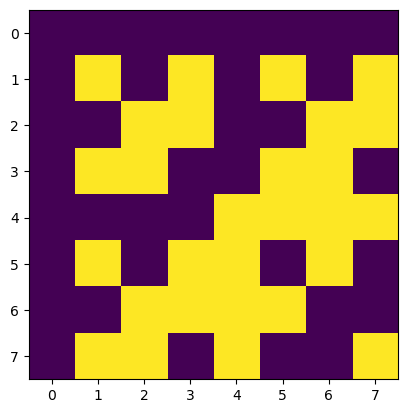

____________________________This works_____________________________________ 40
couplings =  [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 1), (0, 2), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 3), (0, 4), (0, 7), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 5), (0, 6), (0, 7), (0, 6), (0, 0)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333326, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.5456289483429901, 0.41956937674483386, 0.2951672353008666, 0.33333333333333337, 0.2163468959387855, 0.33333333333333337, 1.0, 1.0, 1.0, 0.2163468959387855, 0.33333333333333337, 0.2951672353008666, 0.41956937674483386, 1.0, 1.0, 0.5640942168489749, 0.5, 0.49999999999999983, 0.3918265520306073, 1.0, 1.0, 1.3918265520306072, 0.28043779800754365, 0.18642949867733732, 1.0, 1.0, 1.2142925045679323, 0.2677204728012301, 1.0, 1.0, 1.7048327646991335

In [48]:
import numpy as np
from numpy.linalg import norm

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):

    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):

    U = np.asarray(U)
    dim = U.shape[0]

    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        return (0,0), 0, 0

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    c = U[i, i].real        
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   

    return (i, j), fraction, phi

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0
    count = 0
    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate", i, theta, col))
        rotation_mats.append(G)
    

    for col in order:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap", col, theta_swap, col))
        rotation_mats.append(G_swap)
        count += 1 
        if count % 2 == 0:
            for i in order[count:][::-1]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
        else:
            for i in order[count:]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats


def givens_rotation_complex(m, j, theta, phi):
    c = np.cos(theta/2)
    s = np.sin(theta/2)
    G = np.eye(m, dtype=complex)
    G[0, 0] = c
    G[0, j] = np.exp(1j*phi)*s
    G[j, 0] = -np.exp(-1j*phi)*s
    G[j, j] = c
    return G

# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 8
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# U = np.real(unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim))

U = np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))
# U = np.real(np.array([[ 1.        -0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j],
#        [ 0.        +0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339+0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j,
#         -0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339+0.j,
#         -0.35355339-0.j, -0.35355339-0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339-0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j]]))
# U = np.real(np.array([
#     [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
#     [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
#     [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
#     [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
# ], dtype=complex))

import itertools

my_list = [1,2,3,4,5,6,7]
# permutations = list(itertools.permutations(my_list))[:10]
permutations = [my_list]
list_lens = []
list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    # coup, f, ph = inverse_single_pulse(compressed[13])
    # print(f)
    # if len(compressed) < len_comp:
    #     print(len(compressed))
        # list_comp.append(compressed)
        # len_comp = len(compressed)
    # print(V_triangular)
    couplings = []
    phases = []
    fractions = []
    # print(len(rotation_mats))
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    # if couplings[0:6]==couplings[7:13][::-1]:
    # # if 3%np.round(fractions[0],2) == 0 and 3%np.round(fractions[12],2) == 0 and np.round(fractions[12],2) != 1:   
    # print('couplings = ',couplings)
    # print('fractions = ', fractions)
    # print('phases = ', phases)
# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    U_reconstructed = np.eye(dim)
    for G in reversed(compressed[:]):
        U_reconstructed = G.T @ U_reconstructed
    print(-1*U_reconstructed)

    import matplotlib.pyplot as plt
    plt.imshow(U_reconstructed, cmap='viridis', interpolation='nearest')
    plt.show()

    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    a = np.round(np.abs(U_reconstructed),3).tolist()
    b = np.round(np.abs(U),3).tolist()
    list_lens.append(len(couplings))
    # if len(couplings) == 36:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
print('done')

# Haar Measure 
- Sampling random unitaries uniforming using Haar measure. 

-- read up here: [https://pennylane.ai/qml/demos/tutorial_haar_measure]

In [5]:
import numpy as np
def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n,n)) + 1j*rng.standard_normal((n,n)))/np.sqrt(2)
    Q, R = np.linalg.qr(X)
    # print(R)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D
def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U))/n
    return U * np.exp(-1j*phi)

print(haar_su(8,2))

[[ 0.08548838+1.49688045e-01j -0.14781378-1.98203211e-01j
  -0.38405519-3.04546191e-01j -0.51803161-4.01222750e-01j
   0.36107356+3.12538746e-02j -0.0783431 -2.90820119e-01j
  -0.05503518+3.40554236e-02j -0.09876194-5.96750882e-02j]
 [ 0.02547917-2.00525015e-01j -0.11361515+1.07744868e-01j
   0.4581869 -8.87026770e-02j -0.29554074-2.69064930e-01j
   0.08020782-2.10253489e-01j -0.03017488+2.73859225e-01j
   0.60177435+2.52130218e-01j  0.03797141-5.81931616e-02j]
 [ 0.11858247-1.00933963e-01j -0.16636108-1.45173487e-01j
   0.12059443+3.87864247e-01j -0.22496434-1.20298629e-01j
   0.14728072+3.11992057e-02j  0.42082605-3.13878461e-04j
  -0.11623454-3.40767450e-01j  0.59867325+9.55746859e-02j]
 [-0.18311595+3.39793080e-01j  0.13873889-1.66643928e-01j
   0.48718467+2.43684090e-01j -0.3580806 -3.32792004e-02j
  -0.20474084+1.75360671e-01j -0.33883459-1.91704395e-01j
  -0.06370258-2.12580770e-01j -0.20013099+2.53771197e-01j]
 [ 0.24118142-1.71814038e-01j  0.13729471-2.39959016e-01j
   0.03227

# Second itteration of QR decomposition for Star topology

- works for complex unitaries. 

In [17]:
import numpy as np
from numpy.linalg import norm
from math import pi
import matplotlib.pyplot as plt
import itertools
def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    def find_coupled_level(U):
        for j in range(1, U.shape[0]):
            if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                return j
        return None
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)
        matches.append(int(j1 == j2 and j1 is not None))
    return matches

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    I = np.eye(rotation_mats[0].shape[0], dtype=complex)
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]
            j1 = next((j for j in range(1, U1.shape[0]) if np.abs(U1[0, j]) > tol or np.abs(U1[j, 0]) > tol), None)
            j2 = next((j for j in range(1, U2.shape[0]) if np.abs(U2[0, j]) > tol or np.abs(U2[j, 0]) > tol), None)
            if j1 == j2 and j1 is not None:
                combined = U2 @ U1
                if norm(combined - I) < tol:
                    i += 2
                    continue
                else:
                    optimized.append(combined)
                    i += 2
                    continue
        optimized.append(rotation_mats[i])
        i += 1
    return optimized

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim) if abs(U[p, q]) > tol or abs(U[q, p]) > tol]
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def swap_like_left(m, p, q):
    return two_level_left(m, p, q, 0.0 + 0j, 1.0 + 0j)

def star_zero_pair(m, j, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, 0, j, c, s)

def star_qr_decomposition(order, U, tol=1e-10):
    m = U.shape[0]
    rotations_info = []
    rotation_mats = []
    V = U.astype(complex).copy()
    col = 0
    count = 0
    for i in order[::-1]:
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        G = star_zero_pair(m, i, a, b, tol)
        V = G @ V
        rotations_info.append(("rotate", i, None, col))
        rotation_mats.append(G)
    for col in order:
        G_swap = swap_like_left(m, 0, col)
        V = G_swap @ V
        rotations_info.append(("swap", col, None, col))
        rotation_mats.append(G_swap)
        count += 1
        if count % 2 == 0:
            seq = order[count:][::-1]
        else:
            seq = order[count:]
        for i in seq:
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            G = star_zero_pair(m, i, a, b, tol)
            V = G @ V
            rotations_info.append(("rotate", i, None, col))
            rotation_mats.append(G)
        V = G_swap @ V
        rotations_info.append(("swap_back", col, None, col))
        rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats


dim = 4

def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n,n)) + 1j*rng.standard_normal((n,n)))/np.sqrt(2)
    Q, R = np.linalg.qr(X)
    # print(R)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D
def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U))/n
    return U * np.exp(-1j*phi)

H2 = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
U = np.kron(H2, H2)
U  = haar_su(dim, 2)
my_list = [2,3,1]
permutations = list(itertools.permutations(my_list))
# permutations = [my_list]
for order in permutations:
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order, U)
    compressed = compress_rotations(rotation_mats)
    couplings = []
    fractions = []
    phases = []
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    U_reconstructed = -1*np.eye(dim, dtype=complex)
    for G in reversed(compressed[:]):
        U_reconstructed = G.conj().T @ U_reconstructed
    print(U_reconstructed)

    # plt.imshow(np.real(U_reconstructed), cmap='viridis', interpolation='nearest')
    # plt.show()
    # if len(couplings) <= 40:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
    print('||U - U_rec|| =', float(norm(U - U_reconstructed)))
    rabi_freqs = [1]*len(couplings)
    U_target = U
    coupl_opt, fracs_opt, phis_opt = reduce_sequence(
    couplings, rabi_freqs, fractions, phases,
    U_target, dim,
    error_threshold=1e-3)
    print("Optimized length============================", len(coupl_opt))
    print("Optimized Couplings = ", coupl_opt)
    print("Optimized Fractions = ", np.array(fracs_opt))
    print("Optimized Phases = ", np.array(phis_opt))
print('done')                                                                                                                          


[[-0.05709669+0.18978766j -0.05300748-0.54632977j  0.35786636+0.42499958j
  -0.22491192-0.54786518j]
 [ 0.33155101+0.59626733j  0.02737921+0.12964545j  0.35519332+0.33091098j
   0.37542832+0.37466097j]
 [ 0.28161873-0.22471055j -0.57925066+0.38583278j -0.26303544+0.50691885j
   0.05637872-0.23762339j]
 [ 0.25643869-0.54744413j  0.11580723-0.42819021j  0.03425158+0.358211j
  -0.10904101+0.5444334j ]]
____________________________This works_____________________________________ 10
couplings =  [(0, 1), (0, 3), (0, 2), (0, 3), (0, 1), (0, 2), (0, 3), (0, 1), (0, 3), (0, 0)]
fractions =  [0.8200178647686392, 0.4488309584852389, 0.7653601630935009, 0.5235589391147808, 0.28756457622920595, 1.0, 1.0, 0.5757673405921023, 1.0, 0.0]
phases =  [0.2545536314963736, 0.3605569285320291, 1.2143735110709344, 0.17232666631719348, 0.4467059923631944, 0.0, 0.0, 0.43827154113490974, 0.0, 0.0]
||U - U_rec|| = 1.1087258160851866e-15
  Trying removal of pulse 9: err = 1.24e-07
  → Pulse 9 removed (new length 9

# Compressor


Target Unitary (rounded):
[[-0.096-0.173j  0.   +0.682j  0.159-0.323j -0.49 -0.354j]
 [-0.277-0.171j  0.064-0.116j -0.523-0.54j   0.411-0.377j]
 [-0.565+0.488j -0.418-0.208j  0.209-0.34j  -0.187+0.178j]
 [ 0.253+0.484j  0.469-0.282j  0.344-0.167j -0.027-0.505j]]


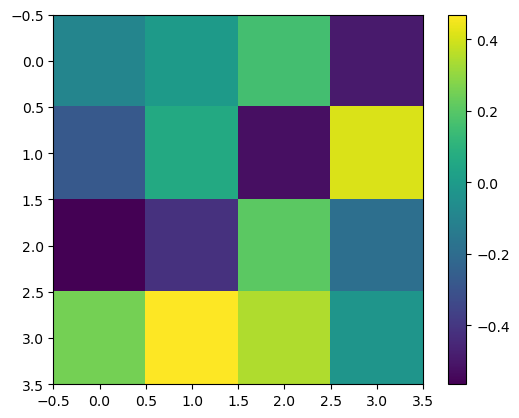

Original sequence length: 10
Original error (should be 0): 0.0
  Trying removal of pulse 9: err = 1.64e-12
  → Pulse 9 removed (new length 9)
  Trying removal of pulse 8: err = 1.49e-01
  Trying removal of pulse 7: err = 4.43e-07
  → Pulse 7 removed (new length 8)
  Trying removal of pulse 7: err = 2.98e-01
  Trying removal of pulse 6: err = 2.98e-01
  Trying removal of pulse 5: err = 8.61e-01
  Trying removal of pulse 4: err = 9.44e-01
  Trying removal of pulse 3: err = 9.52e-01
  Trying removal of pulse 2: err = 8.55e-01
  Trying removal of pulse 1: err = 1.14e+00
  Trying removal of pulse 0: err = 4.94e-01
No further removals possible within threshold.
couplings =  [[0 2]
 [0 3]
 [0 1]
 [0 3]
 [0 2]
 [0 1]
 [0 3]
 [0 3]]
fractions =  [1.68402695 0.72558682 1.12305747 1.34296846 1.24530499 1.49297501
 0.93153511 0.27544341]
phases =  [0.04466712 0.45974652 0.67599756 1.32824495 1.52924592 0.34892364
 0.67229842 0.28294888]

Optimized sequence length: 8
Final error: 4.425095758384734e

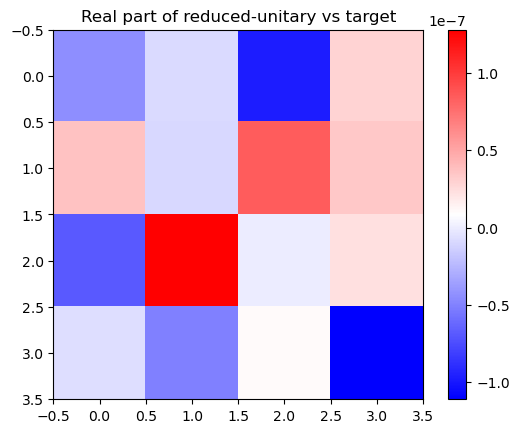

In [7]:
import numpy as np
import math
from scipy.linalg import expm, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import numpy as np
import math  # For np.hypot
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # In the original scheme the phase was given by fix flag * π.
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

dim = 4
# couplings =  [(0, 7), (0, 3), (0, 6), (0, 4), (0, 5), (0, 2), (0, 1), (0, 2), (0, 5), (0, 4), (0, 6), (0, 3), (0, 7), (0, 1), (0, 2), (0, 4), (0, 3), (0, 7), (0, 2), (0, 5), (0, 6), (0, 3), (0, 5), (0, 4), (0, 6), (0, 7), (0, 4), (0, 6), (0, 3), (0, 6), (0, 0), (0, 0)]
# fractions =  [1.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 0.7699465438373841, 0.45437105165701, 0.4195693767448337, 0.2951672353008666, 0.33333333333333326, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 1.0, 0.33333333333333326, 0.3918265520306073, 1.0, 1.0, 1.6666666666666667, 0.49999999999999983, 1.0, 1.0, 1.6081734479693928, 0.5000000000000002, 1.0, 1.0, 1.0, 1.0, 0, 0]
# phases =  [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0]


couplings =  [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 1), (0, 2), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 3), (0, 4), (0, 7), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 5), (0, 6), (0, 7), (0, 6), (0, 0)]
fractions =  [0.8309853544413607, 0.405074459183113, 0.1351381493190214, 0.21681852831883802, 0.2614297151954402, 0.10165700631718896, 0.870422580467167, 0.6100471480035311, 0.4727901526508611, 0.39339181207771656, 0.6433786099750364, 0.2762345548325639, 0.1792085741624918, 1.0, 1.0, 0.8164549214589332, 0.10370568396537178, 0.07142920960102593, 0.40101764874596435, 0.5482777740755138, 1.0, 1.0, 0.17896324655303605, 0.2451157215691435, 0.3009553844069261, 0.2782368577512706, 1.0, 1.0, 0.1580592435710827, 0.03204681254878147, 0.17880203841870163, 1.0, 1.0, 0.7771023221585398, 0.3139247614635512, 1.0, 1.0, 0.7380895853859131, 1.0, 0.0]
phases =  [0.5067006073488289, 1.1345532135272818, 1.689379565184463, 0.19703057729468287, 1.3426643417203477, 0.22446369983462838, 1.4597703933793893, 1.5349492454767724, 0.25253239577826553, 0.38741821849844643, 1.7932976737811432, 0.4063374724369041, 1.8860259599544964, 0.0, 0.0, 0.10830559611648204, 1.5432919316730027, 0.06032296837401695, 0.48531420626446714, 1.9687261067736828, 0.0, 0.0, 0.6751653928064848, 1.0324876925834237, 1.0496379519628358, 1.4781595262178786, 0.0, 0.0, 1.3532182368416654, 0.5895329435433218, 1.3789522675115102, 0.0, 0.0, 0.1269599285460637, 1.734357062143504, 0.0, 0.0, 0.027972071412101337, 0.0, 0.0]
couplings =  [(0, 2), (0, 3), (0, 1), (0, 3), (0, 2), (0, 1), (0, 3), (0, 2), (0, 3), (0, 0)]
fractions =  [0.6798331930335908, 0.6197410062812447, 0.5220058628194674, 0.8804945446447829, 0.15327903076798327, 1.0, 1.0, 0.45509092711847554, 1.0, 0.0]
phases =  [0.8073938367195502, 0.3605569285320291, 0.6615333058477578, 0.8219949895588408, 1.967541668709914, 0.0, 0.0, 0.7092217749781797, 0.0, 0.0]
fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)


# dim = 4
# couplings =  [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 1), (0, 2), (0, 3), (0, 2), (0, 0)]
# fractions =  [1.5, 0.3918265520306073, 0.6666666666666667, 0.3918265520306073, 0.5, 1.0, 1.0, 1.0, 1.0, 0]
# phases =  [1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.0]
# fixed_phase_flags = phases
# rabi_freqs = [1]*len(couplings)
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# Build the target unitary using the original pulses.
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()

def compute_error(x, couplings, rabi_freqs, U_target, dim):
    """
    x = [f0, f1, ..., f_{M-1}, phi0, phi1, ..., phi_{M-1}]
    returns Frobenius norm ||U_seq(params) - U_target||.
    """
    M = len(couplings)
    fracs  = x[:M]
    phis   = x[M:]
    # print(phis)
    U_seq  = unitary(couplings, rabi_freqs, fracs, phis, dim)
    return norm(U_seq - U_target, 'fro')

def optimize_sequence(couplings, rabi_freqs, init_fracs, init_phis,
                      U_target, dim,
                      bounds_frac=[(0,2)], bounds_phi=[(0,2)],
                      maxiter=10000):
    M = len(couplings)
    x0 = np.hstack([init_fracs, init_phis])
    # build bounds arrays
    bnds = bounds_frac * M + bounds_phi * M
    res = minimize(
        compute_error, x0,
        args=(couplings, rabi_freqs, U_target, dim),
        method='L-BFGS-B',
        bounds=bnds,
        options={'maxiter': maxiter}
    )
    fracs_opt = res.x[:M]
    phis_opt  = res.x[M:]
    return fracs_opt, phis_opt, res.fun

def reduce_sequence(couplings, rabi_freqs, fracs, phis,
                    U_target, dim,
                    error_threshold=1e-3):
    """
    Greedily try 
    
    removing each pulse; if after re-optimizing the remaining pulses
    the error is below threshold, accept the removal and restart.
    """
    changed = True
    while changed and len(couplings) > 1:
        changed = False
        for i in range(len(couplings))[::-1]:
            # build trial sequence with pulse i removed
            c_trial = couplings[:i] + couplings[i+1:]
            f_trial = fracs[:i] + fracs[i+1:]
            p_trial = phis[:i]  + phis[i+1:]
            # re-optimize
            f_opt, p_opt, err = optimize_sequence(
                c_trial, rabi_freqs[:len(c_trial)],
                f_trial, p_trial,
                U_target, dim
            )
            print(f"  Trying removal of pulse {i}: err = {err:.2e}")
            if err < error_threshold:
                print(f"  → Pulse {i} removed (new length {len(c_trial)})")
                couplings = c_trial
                fracs     = list(f_opt)
                phis      = list(p_opt)
                rabi_freqs= rabi_freqs[:len(c_trial)]
                changed   = True
                break
        if not changed:
            print("No further removals possible within threshold.")
    return couplings, fracs, phis


U_target = A2
# show original
print("Original sequence length:", len(couplings))
print("Original error (should be 0):",
      compute_error(np.hstack([fractions, phases]),
                    couplings, rabi_freqs, U_target, dim))

# try to reduce
coupl_opt, fracs_opt, phis_opt = reduce_sequence(
    couplings, rabi_freqs, fractions, phases,
    U_target, dim,
    error_threshold=1e-1
)

print("couplings = ",np.array(coupl_opt))
print("fractions = ", np.array(fracs_opt))
print("phases = ", np.array(phis_opt))
print("\nOptimized sequence length:", len(coupl_opt))
print("Final error:",
      compute_error(np.hstack([fracs_opt, phis_opt]),
                    coupl_opt, rabi_freqs[:len(coupl_opt)],
                    U_target, dim))

# (optional) visualize
U_red = unitary(coupl_opt, rabi_freqs[:len(coupl_opt)],
                       fracs_opt, phis_opt, dim)
plt.figure()
plt.title("Real part of reduced-unitary vs target")
plt.imshow(np.real(U_red - U_target), cmap='bwr')
plt.colorbar()
plt.show()